## 超分辨率 Learning Project

[参考1: Super_Resolution](https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/07_Super_Resolution.ipynb)\
[参考2: superres-gan](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres-gan.ipynb)

https://zhuanlan.zhihu.com/p/87253140

概要:

* Image -> Image 数据加载方式
* Unet 来实现超分

## Init fast ai 💐🎄🐡

In [ ]:
#hide
!pip install -Uq fastai
import fastai
from fastai.vision.all import *
from fastai.vision import *
from fastai.callback import *
from fastai.vision.gan import *
import shutil
import os

from google.colab import drive
drive.mount('/content/gdrive')
grive_path = '/content/gdrive/MyDrive/fast_ai/'

Mounted at /content/gdrive


## Data 💐🎄🐡

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'
path_gen = path/'image_gen'

### crappify data 💐🐡

In [ ]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
        
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [ ]:
import glob
imgs = [Path(i) for i in glob.glob(str(path_hr)+'/*.jpg')]
parallel(crappifier(path_lr, path_hr), imgs)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

<AxesSubplot:>

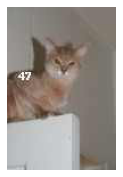

In [ ]:
bad_imgs = get_image_files(path_lr)
im1 = PILImage.create(bad_imgs[0])
im1.show()

### load superres initial result for critic

In [ ]:
import zipfile
def save_superres_image():
  # zip file
  shutil.make_archive('image_gen', 'zip', path_gen)
  shutil.copy('image_gen.zip', gdrive_path+'image_gen.zip')

def load_superres_images():
  shutil.copy(gdrive_path+'image_gen.zip', 'image_gen.zip')
  with zipfile.ZipFile('image_gen.zip', 'r') as zip_ref:
      zip_ref.extractall(path_gen)

### data loader for superres gan

In [ ]:
def get_dls(bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                    get_items=get_image_files,
                    get_y=lambda x: path_hr/x.name,
                    splitter=RandomSplitter(),
                    item_tfms=Resize(size),
                    batch_tfms=[*aug_transforms(max_zoom=2.),
                                Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3
  return dls

### data loader for critic

In [ ]:
# https://docs.fast.ai/tutorial.datablock.html
def get_crit_dls(image_list, bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     splitter=RandomSplitter(),
                     item_tfms=Resize(size),
                     batch_tfms=Normalize.from_stats(*imagenet_stats),
                     get_x = lambda imgs: imgs,
                     get_y = parent_label)
  return dblock.dataloaders(image_list, bs=bs, path=path)

## Learner

### Unet superres learner

一些参数的解释:
* `wd`\
  wd is the default weight decay used when training the model.
* `norm_type` \
  [Batch Normalization Type](https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6)

* `blur`\
  [Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts](https://arxiv.org/abs/1806.02658)  where the authors add a little bit of blur to completely get rid of checkerboard artifacts.

* `self_attension`\
  Self-attention layer as introduced in [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318)

* `y_range`\
  y_range is passed, the function adds a SigmoidRange to that range

In [ ]:
wd, y_range, loss_gen, bbone = 1e-3, (-3., 3.), MSELossFlat(), resnet34

In [ ]:
def create_gen_learner(dls_gen):
  return unet_learner(dls_gen, bbone, wd=wd, loss_func=loss_gen, 
                      blur=True, norm_type=NormType.Weight,
                      self_attention=True, y_range=y_range)

In [ ]:
def save_learner(learner_obj, fname):
  path = learner_obj.save(fname)
  shutil.copy(path, grive_path+fname+'.pth')

### Critic Learner

BCE: Binary Cross Entropy
$$
l = -w[y\cdot \log x + (1-y) \cdot\log (1-x))]
$$
BCEWithLogitsLoss 自带sigmoid
$$
l = -w[y\cdot \log \sigma(x) + (1-y) \cdot \log(1-\sigma(x))]
$$

这里$\sigma(x) = \frac{1}{1+e^{-x}}$ sigmoid 函数.

参考: [Loss function — CrossEntropyLoss vs BCELoss in Pytorch; Softmax vs sigmoid; Loss calculation](https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23)

这里使用AdaptiveLoss是因为gan_critic()得到的是一个动态大小的输出(不同大小的图片输出大小也不一样). [why-use-adaptive-loss-for-gan](https://forums.fast.ai/t/why-use-adaptive-loss-for-gan-critic/52956)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_crit_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)    

## PreTrain Unet For Superres 💐

### Train Unet

In [ ]:
dls_gen = get_dls(32, 128)

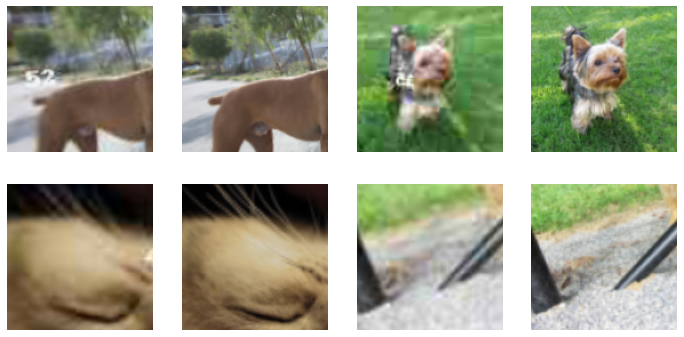

In [ ]:
dls_gen.show_batch(max_n=4)

In [ ]:
# size of batch, batch size, dataset size
len(dls_gen.train), dls_gen.bs, len(dls_gen.dataset.items)

(184, 32, 5912)

In [ ]:
# input, output image size
ob = dls_gen.one_batch()
ob[0].shape, ob[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 3, 128, 128]))

In [ ]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.073838,0.058340,01:34
1,0.039926,0.039214,01:29


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.038072,0.038018,01:34
1,0.035279,0.035033,01:31
2,0.033671,0.034119,01:34


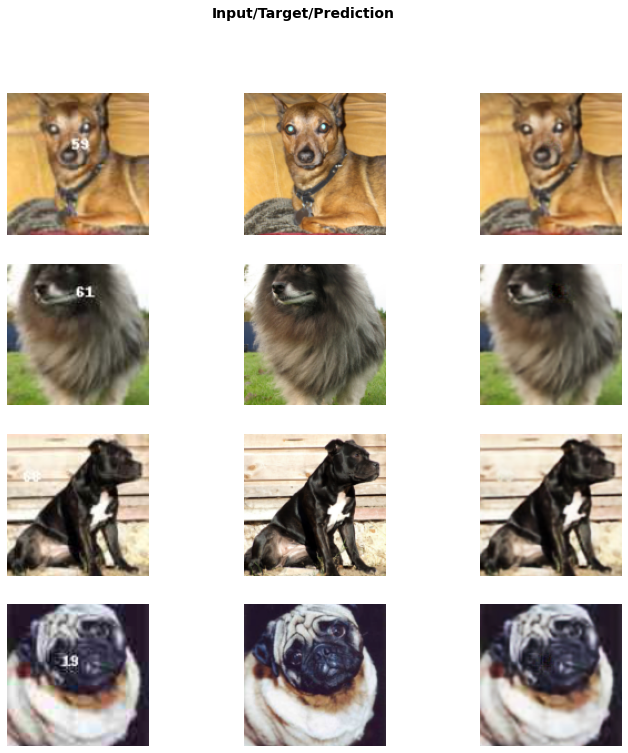

In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))

### Save Result

In [ ]:
save_learner(learn_gen, 'gen-pre2')

In [ ]:
save_superres_image()

## PreTrain Critic 🎄

In [ ]:
if not path_gen.exists():
    load_superres_images()

In [ ]:
image_list = get_image_files(path_gen) + get_image_files(path_hr)

In [ ]:
dls_crit = get_crit_dls(image_list, 32, 128)

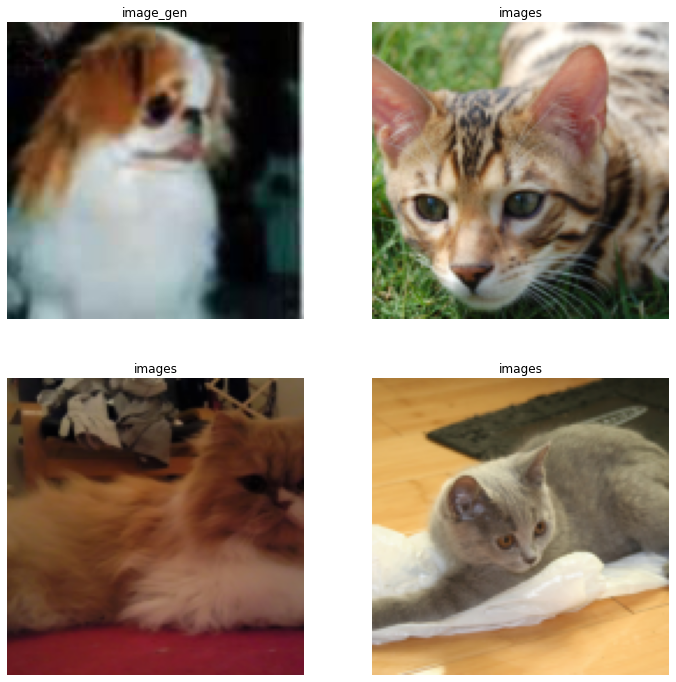

In [ ]:
dls_crit.show_batch(max_n=4, figsize=(12,12))

### critic learner

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [ ]:
#learn_crit.summary()

In [ ]:
#model = gan_critic()
#model

In [ ]:
learn_crit.fit_one_cycle(6, 1e-3, wd=1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time


In [ ]:
save_learner(learn_crit, 'crit-pre2')

Path('/root/.fastai/data/oxford-iiit-pet/models/critic-pre2.pth')

## GAN 🐡

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_gen_learner():
  return unet_learner(dls_gen, bbone, wd=wd, loss_func=loss_gen, 
                      blur=True, norm_type=NormType.Weight,
                      self_attention=True, y_range=y_range)

def create_crit_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=1e-3)